In [705]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq
from tqdm import tqdm
import warnings

In [706]:
# TODO: Hook, dass die NB Outputs im pre-commit gecleared werden
# FIXME: Twins werden nicht korrekt gefiltert, colselection ist falsch wegen excluding ub
# NOTE:

# Import Data

In [707]:
#entweder läd er die Daten aus dem path oder aus BQ, wenn nicht gefunden
#definiert dann die Tabelle als globale Variable


class InputData:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.TEST_ITEM_COMMUNICATIONKEYS = self.data["TEST_ITEM_COMMUNICATIONKEY"].unique()
        self.TWIN_ITEM_COMMUNICATIONKEYS = self.data["TWIN_ITEM_COMMUNICATIONKEY"].unique()
        
    def prepare_data(self, num_twins: int, key: int) -> pd.DataFrame:

        #warning, when wanted num_twins higher than twin count
        #at one point i should check that the test length is the same as the twin max length
        # print out quick summary of the data (start date, end date etc)
        # beidees berechnen, nur eines zurückgeben

        if num_twins == 0:
            #case: test item
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)

            df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")
        else:
            #case: twin items
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)

            df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")

            # reduce to wanted number of twin items
            df = df.iloc[:, :num_twins+1]

        #reconsider the method of this step
        #print(f"There are {df.isna().sum().sum()} NaN values in the data which are replaced with 0s.")
        df.fillna(0, inplace=True)
        return df
    
    @staticmethod
    def get_bq_table(table_id, file_path=None, project_id: str = "brain-flash-dev", dataset_id: str = "dagster_common"):
        client = bq.Client(project=project_id)
        table_ref = f"{project_id}.{dataset_id}.{table_id}"

        query = f"SELECT * FROM `{table_ref}`"
        df = client.query(query).to_dataframe()

        if file_path is not None:
            df.to_csv(file_path, index=False)
            print(f"DataFrame saved to {file_path}")
        
        return df

In [708]:
input = InputData(df)
test = input.prepare_data(5, 716679764)

In [709]:
test

TWIN_ITEM_COMMUNICATIONKEY,551971034,585248259,585738281,587081823,596532614,612870460
CALENDAR_DATE,,,,,,
2018-02-09,1.0,0.0,1.0,1.0,0.0,20.0
2018-02-10,1.0,0.0,2.0,5.0,1.0,28.0
2018-02-11,2.0,0.0,6.0,1.0,2.0,43.0
2018-02-12,0.0,0.0,4.0,1.0,0.0,23.0
2018-02-13,0.0,0.0,1.0,0.0,3.0,32.0
...,...,...,...,...,...,...
2018-12-09,3.0,2.0,0.0,0.0,0.0,6.0
2018-12-10,1.0,1.0,0.0,0.0,0.0,5.0
2018-12-11,2.0,2.0,1.0,0.0,0.0,3.0


In [710]:
InputData.get_bq_table("CN_data_to_fetch", file_path='data/twins_100.csv')

DataFrame saved to data/twins_100.csv


,TEST_ITEM_COMMUNICATIONKEY,NA_QUOTA,TWIN_ITEM_COMMUNICATIONKEY,CALENDAR_DATE,ANSPRACHE,ANSPRACHE_MARKETING_IMPUTED,FRACTION_SOLDOUT,TWIN_COUNT,FIRST_ANSPRACHE_DATE,LAST_ANSPRACHE_DATE,FIRST_SOLDOUT_DATE,FIRST_SOLDOUT20_DATE,NA_COUNT,TEST_PERIOD,TWIN_PERIOD
0,716679764,0.0,551971034,2018-02-09,1,1,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,307
1,716679764,0.0,551971034,2018-02-10,1,1,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,307
2,716679764,0.0,551971034,2018-02-11,2,2,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,307
3,716679764,0.0,551971034,2018-02-12,0,0,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,307
4,716679764,0.0,551971034,2018-02-13,0,0,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298787,1711757436,0.0,1711757436,2024-08-08,0,0,0.454545,8,2023-08-14,2024-08-26,2023-11-22,2023-12-05,0,364,364
298788,1711757436,0.0,1711757436,2024-08-09,1,1,0.556273,8,2023-08-14,2024-08-26,2023-11-22,2023-12-05,0,364,364
298789,1711757436,0.0,1711757436,2024-08-10,0,0,0.545455,8,2023-08-14,2024-08-26,2023-11-22,2023-12-05,0,364,364
298790,1711757436,0.0,1711757436,2024-08-11,0,0,0.545455,8,2023-08-14,2024-08-26,2023-11-22,2023-12-05,0,364,364


In [711]:
df = pd.read_csv('data/twins_100.csv')

### Bootstrap

In [712]:
class Sampling:
    num_samples = 50000 # maintained on class level to ensure comparability between experiments
    
    @classmethod
    def lb_bootstrap(cls, data: pd.DataFrame, window_size: int, b: int) -> pd.Series:
        """
        Performs the Local Block Bootstrap (LBB) method from Paparoditis and Politis (2002) 
        in a vectorized manner with NumPy, adapted to work on multiple sample series.
        
        Parameters:
        - data: pd.DataFrame -> Input time series data
        - B: float -> Locality parameter to determine window size
        - b: int -> Block size for bootstrapping
        
        Returns:
        - pd.Series -> Summed bootstrap samples
        """
        
        N, col = data.shape

        # Number of blocks
        M = int(np.ceil(N / b))

        # Precompute column choices for each bootstrap sample
        col_choices = np.random.randint(col, size=(cls.num_samples, M))  # Shape: (num_samples, M)

        # Compute Neighborhood window starting and ending indices for each block m
        #J_1m = np.maximum(1, np.arange(M) * b - N * B)  # Shape: (M,)
        #J_2m = np.minimum(N - b + 1, np.arange(M) * b + N * B)  # Shape: (M,)

        J_1m = np.maximum(1, np.arange(M) * b - 0.5*window_size)-1  # Shape: (M,) # first argument used to be 1
        J_2m = np.minimum(N - b + 1, np.arange(M) * b + 0.5*window_size)-1  # Shape: (M,) # first argument used to be N - b + 1
        #adjustments had to be made because the ub in random.randint is exclusive thus trwoing an error when J_1m = J_2m

        # print(b)
        # print(M)
        # print(N)
        # print(J_1m)
        # print(J_2m)

        # Generate block starting indices for each block m
        I_m = np.random.randint(J_1m, J_2m+1, size=(cls.num_samples, M))  # Shape: (num_samples, M)

        # Generate row index ranges for each block (vectorized)
        row_ranges = I_m[:, :, None] + np.arange(b)  # Shape: (num_samples, M, b)

        # print(row_ranges)

        # Extract sampled blocks from data using NumPy advanced indexing
        sampled_blocks = data.values[row_ranges, col_choices[:, :, None]]  # Shape: (num_samples, M, b)

        # Flatten each sample into a 1D time series and truncate to length N
        bootstrap_samples = sampled_blocks.reshape(cls.num_samples, -1)[:, :N]  # Shape: (num_samples, N)
        #Christian: soll lieber Zeitreihe vorher auf Vielfaches von b kürzen, als unvollständige Blöcke zu verwenden

        return pd.Series(np.sum(bootstrap_samples, axis=1), name="Bootstrap_Sums")
    
    @classmethod
    def iid_bootstrap(cls, data: pd.DataFrame) -> pd.Series:
        """Performs IID bootstrap resampling method on the dataset, adapted to work on multiple sample series.
            By defining B as 1 the window size is equal N and with blocksize = 1, we sample individual obersevations."""
        return Sampling.lb_bootstrap(data, B = 1, b = 1)

### Evaluation

$$
W_p(\mu_1, \mu_2) = \left( \int_0^1 \left| F_1^{-1}(q) - F_2^{-1}(q) \right|^p \, dq \right)^{\frac{1}{p}}
$$


In [713]:
class Evaluation:

    @staticmethod
    def mse(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Squared Error (MSE) as decomposed into bias^2 and variance.
        
        Parameters:
        - test_data: The ground truth value for comparison (assumed seasonal demand sum).
        - bootstrap_samples: A Pandas Series of bootstrap sample estimates.
        
        Returns:
        - MSE value as a float.
        """
        bias = (np.mean(bootstrap_samples) - np.sum(test_data, axis=0)) ** 2
        
        variance = np.var(bootstrap_samples, ddof=1)  # Using sample variance (ddof=1 for unbiased estimator)
        
        mse = bias + variance
        return mse
    
    @staticmethod
    def mape(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Percentage Error (MAPE) as a percentage value.
        """
        return np.mean(np.abs(bootstrap_samples - np.sum(test_data)) / np.sum(test_data)) * 100

    @staticmethod
    def mae(test_data: pd.Series, bootstrap_samples: pd.Series) -> float:
        """
        Computes the Mean Absolute Error (MAE).
        """
        return np.mean(np.abs(bootstrap_samples - np.sum(test_data)))

    @staticmethod
    def discrete_wasserstein(dist1: pd.Series, dist2:pd.Series, p: int= 2):
        """
        Compute the p-Wasserstein distance between two discrete one dimensional distributions.
        
        Parameters:
        - dist1: np.array, first distribution samples
        - dist2: np.array, second distribution samples
        - p: int, order of Wasserstein distance
        
        Returns:
        - Wasserstein-p distance (float)
        """
        dist1_sorted = np.sort(dist1)
        dist2_sorted = np.sort(dist2)

        return np.power(np.sum(np.abs(dist1_sorted - dist2_sorted) ** p) / len(dist1), 1 / p)

### Determine values for locality factor B

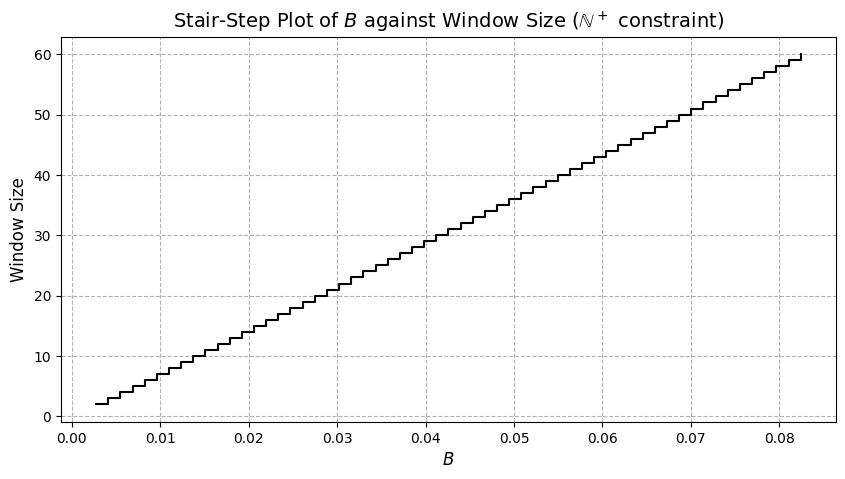

In [714]:
N = 364
# -> which values of B create the window sizes of 60 days? (also include B = 1 because its our benchmark)
max_window_size = 60
# Compute B values
B_for_int = np.arange(2, max_window_size + 1) / (2 * N)# achtung habe hier start auf 2 gesetzt!!!!

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the stair function in black and white
ax1.plot(B_for_int, B_for_int * N * 2, drawstyle='steps-post', color='black')

# Set labels and title with correct LaTeX formatting
ax1.set_xlabel(r'$B$', fontsize=12)
ax1.set_ylabel("Window Size", fontsize=12, color='black')  # Updated y-axis label
ax1.tick_params(axis='y', labelcolor='black')

# Update title with definition that window size must be a natural number (not including 0)
ax1.set_title(r'Stair-Step Plot of $B$ against Window Size ($\mathbb{N}^+$ constraint)', fontsize=14)

# Set grid and show plot
ax1.grid(True, linestyle='--', color='gray', alpha=0.6)
plt.show()

### Determine values for window size b

In [715]:
#reasonable max block size?
max_block_size = 30
block_sizes = np.arange(2, max_block_size + 1) #starting at 2 because otherwise sampling will throw an error
max_window_size = 60
window_size = np.arange(2, max_window_size + 1) #starting at 2 because otherwise sampling will throw an error
param_grid = [(w, b, 10) for w in window_size for b in block_sizes]

### Parameter grid tuning

In [716]:
def run_evalutation(input_data, window_size: int, num_twins: int, b: int) -> pd.DataFrame:
    results_list = []  # Use a list to store results

    for testitems in input_data.TEST_ITEM_COMMUNICATIONKEYS:
        # Compute bootstrap result
        result = Sampling.lb_bootstrap(input_data.prepare_data(num_twins, testitems), window_size, b)

        # Compute MSE
        mse = Evaluation.mse(input_data.prepare_data(0, testitems), result)

        # Append result as a dictionary
        results_list.append({
            "TEST_ITEM_COMMUNICATIONKEY": testitems,
            "window_size": window_size,
            "b": b,
            "num_twins": num_twins,
            "MSE": np.mean(mse)
        })

    # Convert list of results into a DataFrame (efficient)
    results_df = pd.DataFrame(results_list)
    return results_df

In [717]:
evaluation.head()

,TEST_ITEM_COMMUNICATIONKEY,B,b,num_twins,MSE
0,716679764,0.097403,7,10,TWIN_ITEM_COMMUNICATIONKEY 716679764 256720...
1,735286989,0.097403,7,10,TWIN_ITEM_COMMUNICATIONKEY 735286989 33561....
2,796628327,0.097403,7,10,TWIN_ITEM_COMMUNICATIONKEY 796628327 13065....
3,803656013,0.097403,7,10,TWIN_ITEM_COMMUNICATIONKEY 803656013 736343...
4,804245827,0.097403,7,10,TWIN_ITEM_COMMUNICATIONKEY 804245827 10567....


In [718]:
def run_grid_search (param_grid, input_data):
    
    grid_search_results = pd.DataFrame()
    for w, b , num_twins in tqdm(param_grid, desc="Grid Search Evaluation"):
        try:
            run_results = run_evalutation(input_data, w, num_twins, b)
            print(f"Succes for window_size = {w}, b = {b}, Twins = {num_twins}")
        except Exception as e:
            print(f"Failed for window_size = {w}, b = {b}, Twins = {num_twins}")
        grid_search_results = pd.concat([grid_search_results, run_results], ignore_index=True)

    return grid_search_results


In [719]:
grid_search_results = run_grid_search(param_grid, InputData(df))

Grid Search Evaluation:   0%|          | 1/1711 [01:09<33:04:13, 69.62s/it]

Succes for window_size = 2, b = 2, Twins = 10


Grid Search Evaluation:   0%|          | 2/1711 [02:04<29:00:55, 61.12s/it]

Succes for window_size = 2, b = 3, Twins = 10


Grid Search Evaluation:   0%|          | 3/1711 [02:08<16:35:40, 34.98s/it]

Failed for window_size = 2, b = 4, Twins = 10


Grid Search Evaluation:   0%|          | 4/1711 [02:11<10:34:24, 22.30s/it]

Failed for window_size = 2, b = 5, Twins = 10
Failed for window_size = 2, b = 6, Twins = 10


Grid Search Evaluation:   0%|          | 6/1711 [02:15<5:24:21, 11.41s/it] 

Failed for window_size = 2, b = 7, Twins = 10
Failed for window_size = 2, b = 8, Twins = 10
Failed for window_size = 2, b = 9, Twins = 10


Grid Search Evaluation:   1%|          | 9/1711 [02:15<2:34:18,  5.44s/it]

Failed for window_size = 2, b = 10, Twins = 10


Grid Search Evaluation:   1%|          | 10/1711 [02:15<2:04:59,  4.41s/it]

Failed for window_size = 2, b = 11, Twins = 10
Failed for window_size = 2, b = 12, Twins = 10
Failed for window_size = 2, b = 13, Twins = 10


Grid Search Evaluation:   1%|          | 16/1711 [02:18<47:02,  1.67s/it]  

Failed for window_size = 2, b = 14, Twins = 10
Failed for window_size = 2, b = 15, Twins = 10
Failed for window_size = 2, b = 16, Twins = 10
Failed for window_size = 2, b = 17, Twins = 10
Failed for window_size = 2, b = 18, Twins = 10
Failed for window_size = 2, b = 19, Twins = 10


Grid Search Evaluation:   1%|          | 19/1711 [02:18<30:16,  1.07s/it]

Failed for window_size = 2, b = 20, Twins = 10
Failed for window_size = 2, b = 21, Twins = 10


Grid Search Evaluation:   1%|▏         | 25/1711 [02:19<13:56,  2.02it/s]

Failed for window_size = 2, b = 22, Twins = 10
Failed for window_size = 2, b = 23, Twins = 10
Failed for window_size = 2, b = 24, Twins = 10
Failed for window_size = 2, b = 25, Twins = 10
Failed for window_size = 2, b = 26, Twins = 10
Failed for window_size = 2, b = 27, Twins = 10


Grid Search Evaluation:   2%|▏         | 28/1711 [02:20<14:30,  1.93it/s]

Failed for window_size = 2, b = 28, Twins = 10
Failed for window_size = 2, b = 29, Twins = 10
Failed for window_size = 2, b = 30, Twins = 10


Grid Search Evaluation:   2%|▏         | 30/1711 [03:33<4:04:21,  8.72s/it]

Succes for window_size = 3, b = 2, Twins = 10


Grid Search Evaluation:   2%|▏         | 31/1711 [04:32<7:22:20, 15.80s/it]

Succes for window_size = 3, b = 3, Twins = 10


Grid Search Evaluation:   2%|▏         | 31/1711 [05:07<4:37:18,  9.90s/it]


KeyboardInterrupt: 

### Test Area

In [439]:
input_data = InputData(df)

for testitems in tqdm(input_data.TEST_ITEM_COMMUNICATIONKEYS, miniters = 10, desc = "Bootstrap Evaluations"):
    result = Sampling.lb_bootstrap(input_data.prepare_data(4, testitems), B = 30/308)
    mse = Evaluation.mse(input_data.prepare_data(0, testitems), result)
    print(f"MSE of test item {testitems}: {mse}")

Bootstrap Evaluations:   0%|          | 0/100 [00:00<?, ?it/s]

There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 716679764: TWIN_ITEM_COMMUNICATIONKEY
716679764    13485.701939
dtype: float64
There are 66 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 735286989: TWIN_ITEM_COMMUNICATIONKEY
735286989    70407.280076
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 796628327: TWIN_ITEM_COMMUNICATIONKEY
796628327    26194.26214
dtype: float64
There are 10 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 803656013: TWIN_ITEM_COMMUNICATIONKEY
803656013    1.209593e+06
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are rep

Bootstrap Evaluations:  10%|█         | 10/100 [00:04<00:42,  2.12it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 813036796: TWIN_ITEM_COMMUNICATIONKEY
813036796    23959.067648
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 815378026: TWIN_ITEM_COMMUNICATIONKEY
815378026    293586.8515
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 821340660: TWIN_ITEM_COMMUNICATIONKEY
821340660    63908.698376
dtype: float64
There are 20 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 821851364: TWIN_ITEM_COMMUNICATIONKEY
821851364    868818.561529
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 824008632: TWIN_ITEM_COMMUNICAT

Bootstrap Evaluations:  20%|██        | 20/100 [00:07<00:29,  2.73it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 831771058: TWIN_ITEM_COMMUNICATIONKEY
831771058    189315.854479
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 831990789: TWIN_ITEM_COMMUNICATIONKEY
831990789    610323.43592
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 832793358: TWIN_ITEM_COMMUNICATIONKEY
832793358    189042.059581
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 832928980: TWIN_ITEM_COMMUNICATIONKEY
832928980    13304.205962
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 832932915: TWIN_ITEM_COMMUNICA

Bootstrap Evaluations:  30%|███       | 30/100 [00:09<00:20,  3.42it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 837663879: TWIN_ITEM_COMMUNICATIONKEY
837663879    362413.97055
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 837668025: TWIN_ITEM_COMMUNICATIONKEY
837668025    84360.783598
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 837717257: TWIN_ITEM_COMMUNICATIONKEY
837717257    7931.471025
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 842058910: TWIN_ITEM_COMMUNICATIONKEY
842058910    1.251282e+06
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 845044335: TWIN_ITEM_COMMUNICATIO

Bootstrap Evaluations:  40%|████      | 40/100 [00:13<00:20,  2.92it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 850564755: TWIN_ITEM_COMMUNICATIONKEY
850564755    367340.261739
dtype: float64
There are 78 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 850575936: TWIN_ITEM_COMMUNICATIONKEY
850575936    824684.501085
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 856030354: TWIN_ITEM_COMMUNICATIONKEY
856030354    3837.498807
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 856030824: TWIN_ITEM_COMMUNICATIONKEY
856030824    22925.750569
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 856065671: TWIN_ITEM_COMMUNICA

Bootstrap Evaluations:  50%|█████     | 50/100 [00:17<00:16,  2.97it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 943969594: TWIN_ITEM_COMMUNICATIONKEY
943969594    304793.055695
dtype: float64
There are 41 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 943981017: TWIN_ITEM_COMMUNICATIONKEY
943981017    115193.093882
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1030393072: TWIN_ITEM_COMMUNICATIONKEY
1030393072    8219.006622
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1035064903: TWIN_ITEM_COMMUNICATIONKEY
1035064903    33935.774167
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1035065755: TWIN_ITEM_COMM

Bootstrap Evaluations:  60%|██████    | 60/100 [00:20<00:12,  3.12it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1063721481: TWIN_ITEM_COMMUNICATIONKEY
1063721481    483833.066886
dtype: float64
There are 102 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1064483626: TWIN_ITEM_COMMUNICATIONKEY
1064483626    18406.418592
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1064587225: TWIN_ITEM_COMMUNICATIONKEY
1064587225    23278.500681
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1064614421: TWIN_ITEM_COMMUNICATIONKEY
1064614421    182573.176008
dtype: float64
There are 92 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1064646595: TWIN_IT

Bootstrap Evaluations:  70%|███████   | 70/100 [00:23<00:09,  3.13it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1088136910: TWIN_ITEM_COMMUNICATIONKEY
1088136910    103711.701512
dtype: float64
There are 7 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1088218093: TWIN_ITEM_COMMUNICATIONKEY
1088218093    12662.209904
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1089781589: TWIN_ITEM_COMMUNICATIONKEY
1089781589    212175.537068
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1089827822: TWIN_ITEM_COMMUNICATIONKEY
1089827822    69895.373615
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1091814217: TWIN_ITEM_

Bootstrap Evaluations:  80%|████████  | 80/100 [00:26<00:06,  3.12it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1105151446: TWIN_ITEM_COMMUNICATIONKEY
1105151446    12013.531509
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1105152913: TWIN_ITEM_COMMUNICATIONKEY
1105152913    9073.715855
dtype: float64
There are 318 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1107699346: TWIN_ITEM_COMMUNICATIONKEY
1107699346    169921.142327
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1107705014: TWIN_ITEM_COMMUNICATIONKEY
1107705014    154790.464494
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1108166267: TWIN_ITEM

Bootstrap Evaluations:  90%|█████████ | 90/100 [00:29<00:03,  3.15it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1402591736: TWIN_ITEM_COMMUNICATIONKEY
1402591736    241625.242959
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1556889332: TWIN_ITEM_COMMUNICATIONKEY
1556889332    178406.770998
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1561695466: TWIN_ITEM_COMMUNICATIONKEY
1561695466    23171.071965
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1574713555: TWIN_ITEM_COMMUNICATIONKEY
1574713555    2.872825e+06
dtype: float64
There are 0 NaN values in the data which are replaced with 0s.
There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1582267634: TWIN_ITEM_

Bootstrap Evaluations: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s]

There are 0 NaN values in the data which are replaced with 0s.
MSE of test item 1711757436: TWIN_ITEM_COMMUNICATIONKEY
1711757436    228448.73986
dtype: float64


In [440]:
input_data.prepare_data(0, 716679764).sum()

There are 0 NaN values in the data which are replaced with 0s.


TWIN_ITEM_COMMUNICATIONKEY
716679764    564
dtype: int64

In [ ]:
data = InputData(df)
test = data.prepare_data(0, 716679764)
twin = data.prepare_data(5, 716679764)
print(test.sum())

There are 0 NaN values in the data which are replaced with 0s.
There are 11 NaN values in the data which are replaced with 0s.
TWIN_ITEM_COMMUNICATIONKEY
716679764    564
dtype: int64


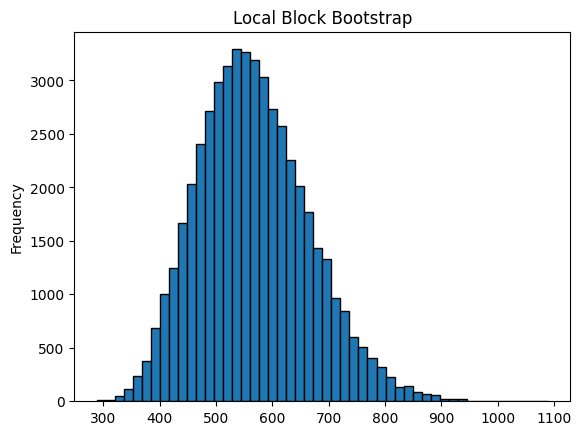

In [ ]:
bootstrap_results = Sampling.lb_bootstrap(test, B=0.1, b=7)
bootstrap_results.plot(kind="hist", bins=50, title="Local Block Bootstrap", edgecolor="black")
plt.show()

count    50000.000000
mean       536.748180
std         49.403277
min        343.000000
25%        503.000000
50%        536.000000
75%        569.000000
max        755.000000
Name: Bootstrap_Sums, dtype: float64

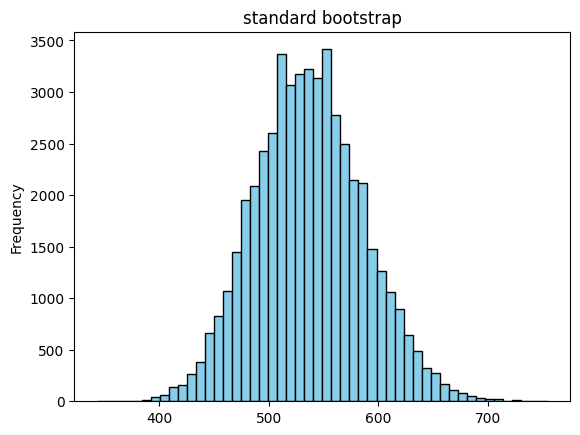

In [443]:
results_simple = Sampling.iid_bootstrap(twin)
display(results_simple.describe())
results_simple.plot(kind="hist", title="standard bootstrap", bins=50, color="skyblue", edgecolor="black");

count    50000.000000
mean       540.354680
std        101.673639
min        185.000000
25%        469.000000
50%        536.000000
75%        606.000000
max       1013.000000
Name: Bootstrap_Sums, dtype: float64


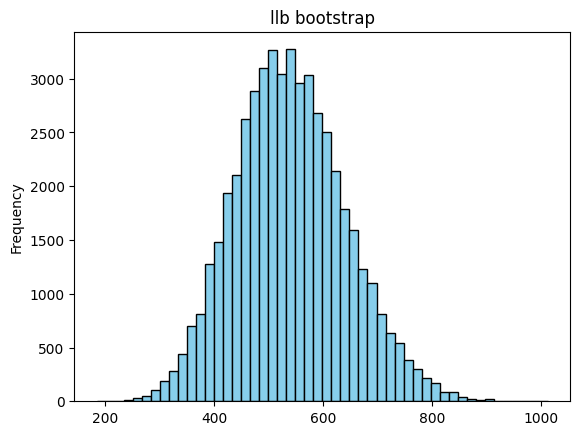

In [445]:
results_lbb = Sampling.lb_bootstrap(twin, B=0.1, b=7)
print(results_lbb.describe())
results_lbb.plot(kind="hist", bins=50, title="llb bootstrap",color="skyblue", edgecolor="black");

# Normality test
- tune number of iteration until distribution is normal

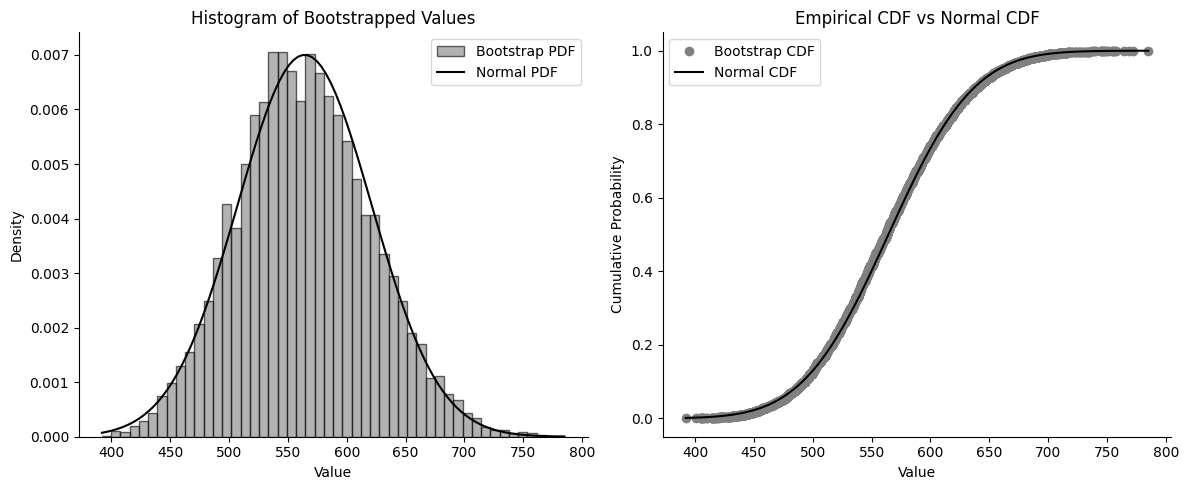

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(results_simple, bins=50, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(results_simple), max(results_simple), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(results_simple)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(results_simple), scale=np.sqrt(np.var(results_simple, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [140]:
#H0: the data is normally distributed
#define alpha level
alpha = 0.05

In [260]:
#generate integer samples from normal distribution
norm_samples = np.random.normal(50, 25, 100000).astype(int)

In [261]:
_, p_value = stats.normaltest(norm_samples)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

0.012248796881928087
Reject the null hypothesis: The data does not appear to be normally distributed.


In [143]:
# Warning: for N > 5000, computed p-value may not be accurate.
_, p_value = stats.shapiro(results_simple)
print(p_value)
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data appears to be normally distributed.")
else:
    print("Reject the null hypothesis: The data does not appear to be normally distributed.")

Reject the null hypothesis: The data does not appear to be normally distributed.


/home/chnaeher/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
